In [1]:
# 100% 
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import pickle
import time
import sys
from collections import Counter
from scipy.special import expit, logit

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [ ]:
# ==================== Define functions ====================

def Extract_Features(PD, Type = 'Full_Cov'): # Functions that only extract interesting features, remove unrelated columns in the pandas dataframe
    # Input PD is the entire pandas dataframe read from csv (result from Rds files of R)
    # Type is an approach that you want to run
    #   - Full_Cov: Keep all features --> remove x-y coordinates and FOI column
    #   - Only_Bio: Only keep Bioclimatic Features --> remove x-y coordinates, FOI column, and other not-bioclimatic columns
    # Output is an pandas dataframe containing only interesting features columns
    # Note: You need to check the names of columns that you want to remove
    
    if (Type == 'Full_Cov'):
        # Full Covariates --> Using all covariates --> remove x-y coordinates and FOI values columns (keep all features)
        if ('FOI' in PD.columns): # This check is for Endemic dataframe since it does not have FOI column    
            Interest_Features = PD.drop(['x', 'y', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y'], axis = 1)
    else:
        # Only Bio Covariates --> Only using bioclimatic --> remove x-y coordinates, FOI columns, and other columns that are not bioclimatic
        if ('FOI' in PD.columns): 
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD'], axis = 1)
    return Interest_Features

np.random.seed(5) # set seed to regenerate the same random result


# ==================== Set up parameters and Read data ====================

Typemodel = 'Full_Cov' # if Full Cov model --> More detail in above Extract_Features functions
#Typemodel = 'Only_Bio' # if only bio model 

Train_Portion = 0.7 # Portion of Train - Validate - Test
Validate_Portion = (1 - Train_Portion) / 2

resolution_grid = 400
Name_Grid_File = 'Grid_' + str(resolution_grid) + '_' + str(resolution_grid) + '.csv'

print('[Type Model] You have chosen ' + Typemodel)

CurDir = os.getcwd() + '/'
Data_All = CurDir + 'Generate/Python_CSV/EM_Imputed_Features_Study.csv' # 'Directory/to/your/EM_Imputed_Features_Study.csv'
Grid = CurDir + 'Generate/Grids_CSV/' + Name_Grid_File # 'Directory/to/your/Grid/' + Name_Grid_File
Data_EndemicDF = CurDir + 'Generate/Python_CSV/Imputed_Features_Endemic.csv' # 'Directory/to/your/Imputed_Features_Endemic.csv'

# Directory to the folder that you want this script exports files to (remember to have slash '/' at the end)
# Default is to create a subfolder named Python_Export and save result to that subfolder   
Savepath = CurDir + 'Generate/Python_Export/' #@@
if not os.path.exists(Savepath):
    os.makedirs(Savepath)

# Read csv and store in dataframe in pandas
AllData = pd.read_csv(Data_All)
Grid = pd.read_csv(Grid)  
EndemicDF = pd.read_csv(Data_EndemicDF)
EndemicDF = EndemicDF.drop(['FOI'], axis = 1) # remove FOI column (if it has)

# Remove Pop_2015 density (if wanted, since already have Pop_Count people) --> Check feature name again
# AllData = AllData.drop(['Pop_2015'], axis = 1)
# EndemicDF = EndemicDF.drop(['Pop_2015'], axis = 1)

# Check if matching coordinator
if (len(AllData.iloc[:, :2].merge(Grid.iloc[:, :2])) == len(AllData.iloc[:, :2])):
    print('[Checking Calibration] Matched Coordinators')
    # Recreate grid to match with AllData in case of nrow of 2 dataframe is different
    t = pd.merge(AllData.iloc[:, : 2].reset_index(), Grid.iloc[:, : 2].reset_index(), on=['x','y'], suffixes=['_1','_2'])
    Grid = Grid.iloc[t['index_2'], :]
    del t
else:
    sys.exit('[Stop Program] Grid and Data File do not match coordinators --> Check again')


# ==================== Sampling Grids to define which Grids will be for Train-Validate-Test ====================

# Count freq of pix in each grid
Grid_column = Grid.iloc[:, 2]
Grid_column = np.array(Grid_column)
d = Counter(Grid_column)
grid_freq = np.array(list(d.values())) # number of pix in each grid_numb (belowed)
grid_numb = np.array(list(d.keys()))
del d

# ----- Preprocessing for Sampling train and validate -----
idx_grid_numb_less = np.where(grid_freq < 100)[0] # find idx of grid containing less than 100 pix --> these grids will be automaticly in training set
idx_grid_numb_high = np.where(grid_freq >= 100)[0] # find idx of grid containing more than 100 pix --> these grids will be randomly chosen for training

grid_numb_train_1 = grid_numb[idx_grid_numb_less]
grid_numb_sample = grid_numb[idx_grid_numb_high]

ngrid_train_2 = round(len(grid_numb_sample)*0.7) # 70% train --- 30% test (validate)
ngrid_validate = round(len(grid_numb_sample)*0.15)
ngrid_test = len(grid_numb_sample) - ngrid_train_2 - ngrid_validate
ngrid_train = len(grid_numb_train_1) + ngrid_train_2

print('[Sampling Grid] Training Grids: ' + str(ngrid_train) + ' ----- Validating Grids: ' + str(ngrid_validate) + ' ----- Testing Grids: ' + str(ngrid_test))

print('===== Sampling Model =====')    
grid_numb_sample_shuffle = np.copy(grid_numb_sample)
np.random.shuffle(grid_numb_sample_shuffle)
grid_numb_train_2 = grid_numb_sample_shuffle[:ngrid_train_2]
grid_numb_validate = grid_numb_sample_shuffle[ngrid_train_2:(ngrid_train_2 + ngrid_validate)]
grid_numb_test = grid_numb_sample_shuffle[(ngrid_train_2 + ngrid_validate):]
grid_numb_train = np.append(grid_numb_train_1, grid_numb_train_2)
del grid_numb_sample_shuffle, grid_numb_train_2

# ----- Take index of pixel for each sub-dataset
idx_train = np.where(np.in1d(Grid_column, grid_numb_train))[0]
idx_validate = np.where(np.in1d(Grid_column, grid_numb_validate))[0]
idx_test = np.where(np.in1d(Grid_column, grid_numb_test))[0]

Type = np.zeros(AllData.shape[0])
Type[idx_train] = 1 # index 1 for train
Type[idx_validate] = 2 # index 2 for validate
Type[idx_test] = 3 # index 3 for validate

# Saving Sampling Grid index having 3 columns: x-y coordinates, and Grid index
Coor_Grid_Index = AllData.iloc[:, 0:2]
Coor_Grid_Index = Coor_Grid_Index.assign(Type = pd.Series(Type).values)
filename_grid = 'Grid_Index_' + str(resolution_grid) + '.csv'
print('[Saving] Save Grid Index')
Coor_Grid_Index.to_csv(Savepath + filename_grid, sep='\t', encoding='utf-8')
print('[Saving] Done Saving Grid Index')


# ==================== Create Train-Validate-Test dataset ====================

# ===== Prepare Train =====
Train = AllData.iloc[idx_train, :]
row_na = Train.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Training containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Train)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Train) * 100, 2)) + '%')
Train_Non_NA = Train.drop(Train.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_train = Extract_Features(Train_Non_NA, Typemodel)
Y_train = Train_Non_NA.FOI
Y_train = np.array(Y_train)

# ===== Prepare Validate =====
Validate = AllData.iloc[idx_validate, :]
row_na = Validate.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Validating containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Validate)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Validate) * 100, 2)) + '%')
Validate_Non_NA = Validate.drop(Validate.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_validate = Extract_Features(Validate_Non_NA, Typemodel)
Y_validate = Validate_Non_NA.FOI
Y_validate = np.array(Y_validate)

# ===== Prepare Test =====
Test = AllData.iloc[idx_test, :]
row_na = Test.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Testing containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Test)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Test) * 100, 2)) + '%')
Test_Non_NA = Validate.drop(Test.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_test = Extract_Features(Test_Non_NA, Typemodel)
Y_test = Test_Non_NA.FOI
Y_test = np.array(Y_test)

# ===== Prepare EndemicDF =====
row_na = EndemicDF.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total EndemicDF containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(EndemicDF)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(EndemicDF) * 100, 2)) + '%')
EndemicDF_Non_NA = EndemicDF.drop(EndemicDF.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_endemic = Extract_Features(EndemicDF_Non_NA, Typemodel)

In [3]:
m_name = 'GB'
print('===== Training Gradient Boosting =====')

# ==============Hyperparameter Tuning with GBoosting

# Random Search
# tune colsample_bytree,n_estimators,max_depth, lambda
# There is a relationship between the number of trees (n_estimators) and the depth of each tree (max_depth)
# Create the parameter grid: gbm_param_grid
# didn't tune alpha as I tuned lambda

# gbr_param_grid = {
#     'learning_rate': [0.0001,0.001, 0.01, 0.05,0.1,0.15,0.3],
#     'n_estimators': range(50,250,10),
#     'max_depth': [4,6,8,10],
#     'min_samples_leaf': [5,10,15], 
#     'subsample': np.arange(3,8)/10
# }
# # Instantiate the regressor: gbm
# gbr = GradientBoostingRegressor()
# # Perform random search: grid_mse
# randomized_mse = RandomizedSearchCV(param_distributions=gbr_param_grid, 
#                                     estimator=gbr, 
#                                     scoring="neg_mean_squared_error",  
#                                     cv=4, #kfolds
#                                     verbose=1,
#                                    n_jobs = -1)
# # Fit randomized_mse to the data
# randomized_mse.fit(X_train, Y_train) #actually, should just use X_train as the combined train and test, as CV will have its own split

# # Print the best parameters
# # print("Best parameters found: ", randomized_mse.best_params_)

# bestp = randomized_mse.best_params_
# print("Best parameters found: ", bestp)

# Use the tuned params on 10% of the data

bestp = {'subsample': 0.5, 
         'n_estimators': 180, 
         'min_samples_leaf': 15, 
         'max_depth': 4, 
         'learning_rate': 0.05}

# save best parameters to csv
bestp_pd = pd.DataFrame(list(bestp.items()), columns = ['Parameters','Value'])
filename_bestp = 'Bestp_' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.csv'
bestp_pd.to_csv(Savepath + filename_bestp, sep='\t', encoding='utf-8')


# ============== Refit GBoost with the optimal params

gbr = GradientBoostingRegressor(n_estimators = bestp['n_estimators'],
                          max_depth = bestp['max_depth'],
                                learning_rate = bestp['learning_rate'],
                                subsample = bestp['subsample'],
                                min_samples_leaf = bestp['min_samples_leaf'],
                                random_state = 123)
start_time = time.time()
gbr.fit(X_train, Y_train)
end_time = time.time()
print('[Training] Finish training')
training_time = round(end_time - start_time, 5) # seconds
print('Training Time: ' + str(training_time) + ' seconds')

yhat = gbr.predict(X_test)

===== Training Gradient Boosting =====
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best parameters found:  {'subsample': 0.6, 'n_estimators': 70, 'min_samples_leaf': 10, 'max_depth': 8, 'learning_rate': 0.15}
[Training] Finish training
Training Time: 3.38326 seconds


train MSE: 0.111856
test MSE: 0.779048
[Saving] Save MSE evaluation


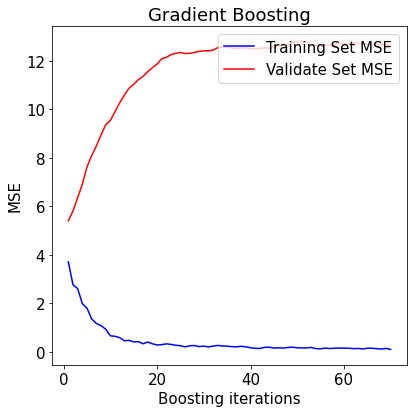

[Saving] Save MSE plot


<Figure size 432x288 with 0 Axes>

In [5]:
# ============== Save the model
# filename_model = Savepath + 'ModelGB_' + '.model'
# print('[Saving] Save training model')
# pickle.dump(gbr, open(filename_model, 'wb'))

# You can load the model by the following way

# filename_model = Savepath + 'ModelGB_' + '.model'
# gbr = pickle.load(open(filename_model, 'rb'))

# ============== 1. MSE
mse_train = mean_squared_error(Y_train, gbr.predict(X_train))
mse_test = mean_squared_error(Y_test, yhat)
print("train MSE: %f" % (mse_train))
print("test MSE: %f" % (mse_test))

# Export csv of MSE
print('[Saving] Save MSE evaluation')        
Result_pd = pd.DataFrame(data = {'mse_train':[mse_train], 'mse_test':[mse_test], 'time_train':[training_time]})   
filename_mse = 'MSE_' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Result_pd.to_csv(Savepath + filename_mse, sep='\t', encoding='utf-8')

# ============== 2. MSE on train/validation

validate_score = np.zeros((bestp['n_estimators'],), dtype=np.float64)
for i, yhat in enumerate(gbr.staged_predict(X_validate)):
    validate_score[i] = gbr.loss_(yhat,Y_validate)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Gradient Boosting')
plt.plot(np.arange(bestp['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(bestp['n_estimators']) + 1, validate_score, 'r-',
         label='Validate Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting iterations')
plt.ylabel('MSE')
plt.rc('font',size = 15)
plt.rc('axes',labelsize = 15)
fig.tight_layout()
plt.show()

# Save MSE plot 
print('[Saving] Save MSE plot')
filename_mse_plot = 'MSE_' + m_name + '_'+ Typemodel + '_' + str(resolution_grid) + '.png'
plt.savefig(Savepath + filename_mse_plot)

[Saving] Save variable importance ranking plot
[Saving] Save variable importance ranking
Top 10 features are:  ['Bio_14' 'Bio_07' 'Bio_15' 'Pigs' 'Bio_12' 'Bio_01' 'Bio_03' 'Elv'
 'Bio_19' 'Bio_11']
[Saving] Save top10 features


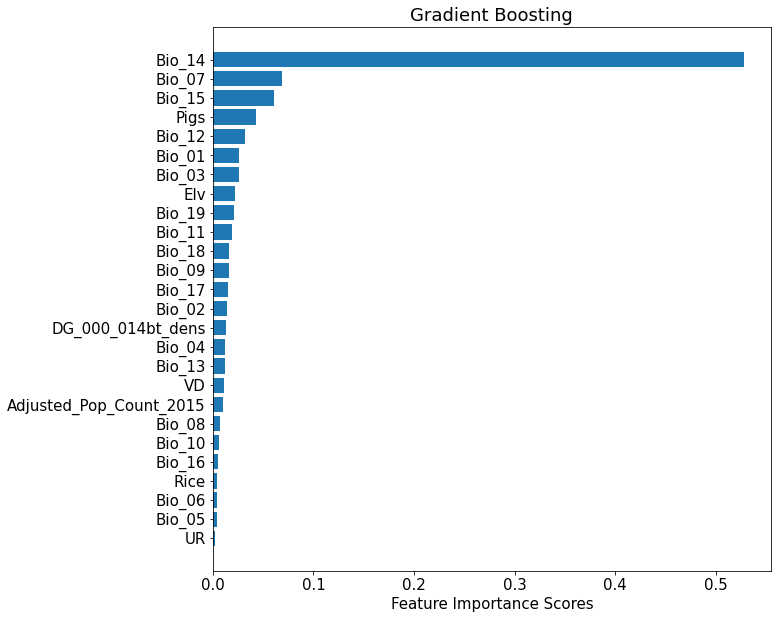

In [8]:
# ============== 1. get feature importances

# feature importance
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(6, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.title('Gradient Boosting')
plt.xlabel('Feature Importance Scores')
plt.rc('font',size = 15)
plt.rc('axes',labelsize = 15)
plt.tight_layout()

# Save feature importance and plot 
print('[Saving] Save variable importance ranking plot')
filename_varimp_plot = 'Varimp' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.png'
plt.savefig(Savepath + filename_varimp_plot)

print('[Saving] Save variable importance ranking')
data = {'Name': X_endemic.columns, 'Importance': feature_importance}
importance_df = pd.DataFrame(data)
importance_df["Std"] = np.std([tree[0].feature_importances_ for tree in gbr.estimators_], axis=0)
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
filename_varimp = 'Varimp' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.csv'
importance_df.to_csv(Savepath + filename_varimp, sep='\t', encoding='utf-8')

# list of top 10 features 

top10 = np.flip(np.array(X_train.columns)[sorted_idx])[:10]
print('Top 10 features are: ', top10)

# Export top10
print('[Saving] Save top10 features')        
Result_pd = pd.DataFrame(data = {'top10':top10})      
filename_mse = 'top10_' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Result_pd.to_csv(Savepath + filename_mse, sep='\t', encoding='utf-8')

[Saving] Save partial dependence plots
[Saving] Save individual conditional expectation plots


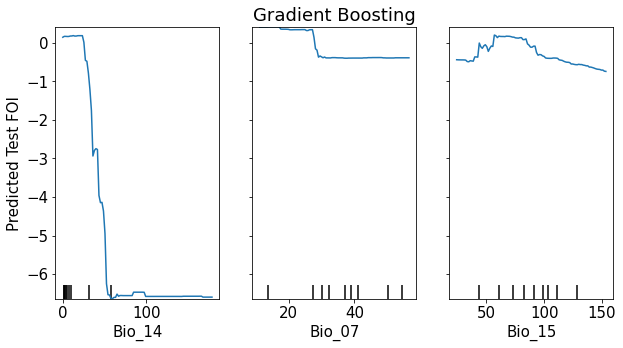

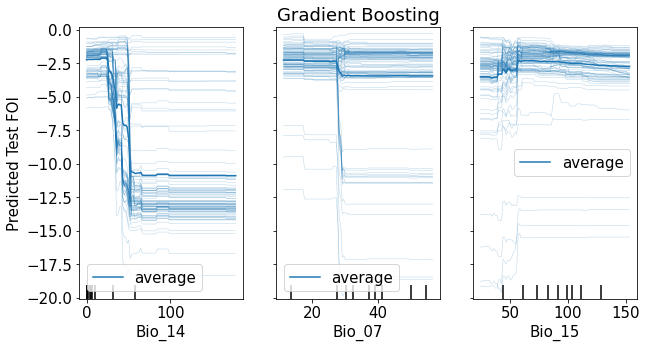

In [13]:
# ============== 2. get dependence plots
# Partial dependence plots
_, ax = plt.subplots(figsize=(10, 5))
ax.set_title( 'Gradient Boosting')
display2 = plot_partial_dependence(gbr,X_test, top10[:3],ax = ax)
display2.axes_[0][0].set_ylabel('Predicted Test FOI')

# Save partial dependence plots
print('[Saving] Save partial dependence plots')
filename_pd_plot = 'PDP' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.png'
ax.figure.savefig(Savepath + filename_pd_plot)

# ICE plots
fig, ax = plt.subplots(figsize=(10, 5))
display3 = plot_partial_dependence(gbr,X_test, top10[:3],ax = ax, kind = 'both', subsample = 100)
ax.set_title('Gradient Boosting')
display3.axes_[0][0].set_ylabel('Predicted Test FOI')

# Save ICE plots 
print('[Saving] Save individual conditional expectation plots')
filename_ice_plot = 'ICE_'+ m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.png'
ax.figure.savefig(Savepath + filename_ice_plot)

In [ ]:
# ============== Prediction intervals
# This is again using quantile regression 

# confidence level
alpha = 0.95
# quantile regression 
clf = GradientBoostingRegressor(loss = 'quantile',alpha = alpha,
    n_estimators = bestp['n_estimators'],
    max_depth = bestp['max_depth'],
    learning_rate = bestp['learning_rate'],
    subsample = bestp['subsample'],
    min_samples_leaf = bestp['min_samples_leaf'],
    random_state = 123)
# upper
clf.fit(X_train, Y_train)
y_upper_gbm = clf.predict(X_test)
y_upper_gbm_end = clf.predict(X_endemic)

# lower
clf.set_params(alpha = 1.0 - alpha)
clf.fit(X_train, Y_train)
y_lower_gbm = clf.predict(X_test)
y_lower_gbm_end = clf.predict(X_endemic)

# yhat
clf.set_params(loss='ls')
clf.fit(X_train, Y_train)
y_pred_gbm = clf.predict(X_test)
y_pred_gbm_end = clf.predict(X_endemic)


[Saving] Save thinned CI plot
[Saving] Save predicted test FOI with coords
[Saving] Save predicted FOI with coords


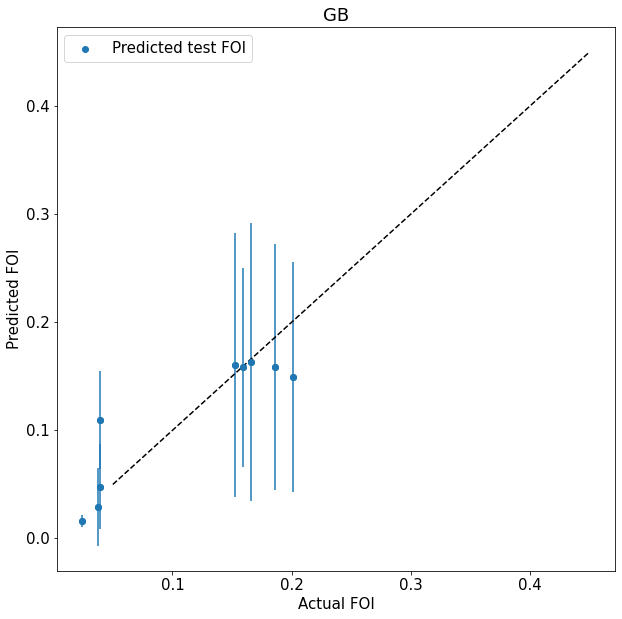

In [21]:
def plotci_2(Y_test, yhat, ylow, yup, m_name):
    # dataframe
    dat = np.concatenate((Y_test.reshape(-1,1), 
                          yhat.reshape(-1,1), 
                          ylow.reshape(-1,1), 
                          yup.reshape(-1,1)),axis = 1)
    dat = pd.DataFrame(dat, columns = ['y','yhat','lower','upper'])

    # sort the dataframe for plotting
    dat2 = dat.sort_values('y')
    
    # take 1% and replot the above CI
    dat2 = dat2.sample(frac = 0.01, replace = False, random_state = 123)

    fig, ax = plt.subplots(figsize = (10,10))
    plt.scatter(dat2['y'], dat2['yhat'],label = 'Predicted test FOI')
    plt.plot([0.05,0.45],[0.05,0.45], 'k--')
    plt.errorbar(dat2['y'], dat2['yhat'], np.array(dat2['lower'], dat2['upper']), fmt='o',alpha = 0.5)

    plt.xlabel('Actual FOI')
    plt.ylabel('Predicted FOI')
    plt.ylim(0,0.5)
    plot_name = m_name
    
    plt.title(plot_name)
    plt.legend()
    plt.rc('font',size = 15)
    plt.rc('axes',labelsize = 15)
    plt.tight_layout()

    # Save thinned CI plot 
    print('[Saving] Save thinned CI plot')
    filename_ci_plot = 'CI_'+ m_name +'_' + Typemodel + '_' + str(resolution_grid) + '.png'
    plt.savefig(Savepath + filename_ci_plot)

plotci_2(Y_test, y_pred_gbm, y_lower_gbm, y_upper_gbm, 'GB')

# ----- Export csv of TestDF (Coor and result)
print('[Saving] Save predicted test FOI with coords')
Coor = Test_Non_NA.iloc[:, 0: 2]
Coor = Coor.assign(Actual = pd.Series(Y_test).values,
                   Predict = pd.Series(y_pred_gbm).values,
                   Lower = pd.Series(y_lower_gbm).values,
                   Upper = pd.Series(y_upper_gbm).values)
filename_test = 'Test_FOI_'+ m_name +'_quantile_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Coor.to_csv(Savepath + filename_test, sep='\t', encoding='utf-8')

# ============== 1. Quantile regression

# ----- Export csv of EndemicDF (Coor and result)
print('[Saving] Save predicted FOI with coords')
Coor = EndemicDF_Non_NA.iloc[:, 0: 2]
Coor = Coor.assign(Predict = pd.Series(y_pred_gbm_end).values,
                  Lower = y_lower_gbm_end,
                  Upper = y_upper_gbm_end)
filename_endemic = 'Endemic_FOI_GB_Quantile Regression_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Coor.to_csv(Savepath + filename_endemic, sep='\t', encoding='utf-8')